In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [3]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import datasets, layers, models
from tensorflow import keras

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train),(x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

4431872/4422102 [==============================] - 0s 0us/step


In [5]:
HP_OPTIMIZER= hp.HParam('optimizer', hp.Discrete(['Adam','SGD','Adadelta','Adagrad','Adamax', 'Ftrl','Nadam','RMSprop']))
METRIC_ACCURACY = 'accuracy'
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(hparams=[HP_OPTIMIZER], metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')])

In [6]:
#reshape inputs for CNN layers
x_train = x_train.reshape(x_train.shape[0], 28,28, 1)
x_test = x_test.reshape(x_test.shape[0], 28,28,1)

In [7]:
# Setting up Model
def train_test_model(hparams):
    model = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv2D(kernel_size=3, filters=12, activation= 'relu', padding='same', input_shape= (28,28,1)),
                                        tf.keras.layers.BatchNormalization(center = True, scale= False),
                                        tf.keras.layers.Conv2D(kernel_size=6, filters=12, activation= 'relu', padding='same', strides= 2 ),
                                        tf.keras.layers.BatchNormalization(center = True, scale= False),
                                        tf.keras.layers.Conv2D(kernel_size=6, filters=12, activation= 'relu', padding='same', strides= 2 ),
                                        tf.keras.layers.BatchNormalization(center = True, scale= False),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(200, activation = 'relu'),
                                        tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.Dense(100, activation = 'relu'),
                                        tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.Dense(60, activation = 'relu'),
                                        tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    # Compile the model
    model.compile(optimizer = hparams[HP_OPTIMIZER], loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=5)
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy

In [8]:
accuracy_values=[]
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
    accuracy_values.append(accuracy)

In [9]:
#Run the experiment for all 8 optimizers
Num =0
optimizers = []
for optimizer in HP_OPTIMIZER.domain.values:
  hparams = {HP_OPTIMIZER: optimizer}    
  run_name = "run-%d" % Num   
  print('--- Starting trial: %s' % run_name)
  print({h.name: hparams[h] for h in hparams})
  run('logs/hparam_tuning/' + run_name, hparams)
  Num += 1
  optimizers.append(optimizer)

--- Starting trial: run-0
{'optimizer': 'Adadelta'}
Epoch 1/5
1875/1875 [==============================] - 26s 5ms/step - loss: 2.7312 - accuracy: 0.1123
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 2.4276 - accuracy: 0.1501
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 2.2451 - accuracy: 0.1978
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 2.0979 - accuracy: 0.2527
Epoch 5/5
313/313 [==============================] - 1s 3ms/step - loss: 1.6501 - accuracy: 0.5502
--- Starting trial: run-1
{'optimizer': 'Adagrad'}
Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 1.2436 - accuracy: 0.5588
Epoch 2/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.8039 - accuracy: 0.7132
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.7102 - accuracy: 0.7484
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6486 - accura

In [10]:
print(accuracy_values)
print(optimizers)

[0.5501999855041504, 0.8282999992370605, 0.8978000283241272, 0.8996000289916992, 0.10000000149011612, 0.9024999737739563, 0.8859000205993652, 0.8819000124931335]
['Adadelta', 'Adagrad', 'Adam', 'Adamax', 'Ftrl', 'Nadam', 'RMSprop', 'SGD']


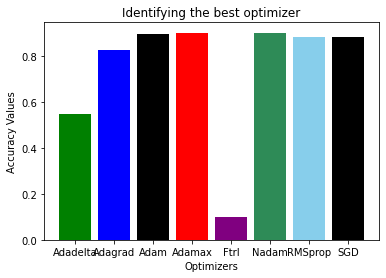

In [11]:
import matplotlib.pyplot as plt
plt.bar(optimizers, accuracy_values, color=['green', 'blue', 'black', 'red','purple', 'seagreen', 'skyblue', 'black'])
plt.xlabel('Optimizers')
plt.ylabel('Accuracy Values')
plt.title('Identifying the best optimizer')
plt.show()